In [2]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import requests
from tqdm import tqdm



Abaixo, seguem dados de produção de soja dos 3 principais produtores. Os dados foram retirados de:

1. Dados até 2022: https://www.sopa.org/statistics/world-soybean-production/?search_type=search_by_period&years=&starting_year_value=2005-2006&ending_year_value=2021-2022&submit=Search
2. API USDA: https://apps.fas.usda.gov/psdonline/app/index.html#/app/home


In [45]:
api_key = {'X-Api-Key': 'wU9gMVMVwN8aD3cfod0lIamDUBCZM8mZfE3AJ0G1'}

attributeID_ = requests.get('https://api.fas.usda.gov/api/psd/commodityAttributes', headers=api_key)
unitId_ = requests.get('https://api.fas.usda.gov/api/psd/commodityAttributes', headers=api_key)

attributeID = pd.json_normalize(attributeID_.json())
unitId = pd.json_normalize(unitId_.json())


1. atributeID 1 é a área plantada unitID 4 são 1000 hectares

2. atributeID 4 é a área colhida

3. atributeID 28 é a produção unitID 8 são 1000 toneladas

4. atributeID 184 é o yield unitID 26 são toneladas por hectare

https://apps.fas.usda.gov/psdonline/app/index.html#/app/downloads



# Importar dados

Importando dados de soja e milho por país para os anos de 2000 até 2024

In [46]:
api_key = {'X-Api-Key': 'wU9gMVMVwN8aD3cfod0lIamDUBCZM8mZfE3AJ0G1'}

commodityCode = ['0440000', '2222000'] # SOJA e MILHO
countryCodes = ['UP','E4','JA',  'MX', 'BR','US', 'AR', 'CH', 'IN', 'PA']  # US, BRASIL, ARGENTINA, CHINA, ÍNDIA, PARAGUAI, JAPÃO, EUROPA, MÉXICO
marketYears = range(2000, 2025)  

database = pd.DataFrame()

for commodity_Code in commodityCode:
    '''
    if (commodity_Code == '2222000'):
        countryCodes = ['BR','US', 'AR', 'CH', 'IN', 'PA', 'JP', 'MX', 'E4']
    else:
        countryCodes = ['E4', 'US', 'BR', 'CH', 'IN', 'JP', 'MX']
        marketYears = range(2000, 2025) 
    '''
    
    for country_code in countryCodes:
        
        for market_year in tqdm(marketYears, desc=f"Processing Years for {country_code} and {commodity_Code}"):

            url = f'https://api.fas.usda.gov/api/psd/commodity/{commodity_Code}/country/{country_code}/year/{market_year}'

            response = requests.get(url, headers=api_key)

            if response.status_code == 200:
                data = response.json()  

                df = pd.json_normalize(data)

                df_filtered = df[(df['attributeId'] == 1) | 
                                 (df['attributeId'] == 4) | 
                                 (df['attributeId'] == 28) | 
                                 (df['attributeId'] == 184)| 
                                 (df['attributeId'] == 57)| 
                                 (df['attributeId'] == 88)| 
                                 (df['attributeId'] == 20)][['commodityCode', 'countryCode', 'marketYear', 'attributeId','value']]

                database = pd.concat([database, df_filtered], ignore_index=True)
            else:
                print(f"Failed to retrieve data for {country_code} in {market_year} (status code: {response.status_code})")

database.to_csv('commodity_data.csv', index=False)
print(database)

Processing Years for PA and 2222000: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]

     commodityCode countryCode marketYear  attributeId       value
0          0440000          UP       2000            4   1279.0000
1          0440000          UP       2000           20    267.0000
2          0440000          UP       2000           28   3848.0000
3          0440000          UP       2000           57     26.0000
4          0440000          UP       2000           88    397.0000
...            ...         ...        ...          ...         ...
3245       2222000          PA       2024           20    187.0000
3246       2222000          PA       2024           28  11200.0000
3247       2222000          PA       2024           57     20.0000
3248       2222000          PA       2024           88   7300.0000
3249       2222000          PA       2024          184      2.9091

[3250 rows x 5 columns]


## Importando total de produção Soja e Milho

In [47]:
marketYears = range(1980, 2025)  

data_total = pd.DataFrame()

for commodity_Code in commodityCode:
    for market_year in tqdm(marketYears, leave=False):

            url = f'https://api.fas.usda.gov/api/psd/commodity/{commodity_Code}/world/year/{market_year}'

            response = requests.get(url, headers=api_key)

            if response.status_code == 200:
                data = response.json()  

                df = pd.json_normalize(data)

                df_filtered = df[(df['attributeId'] == 1) | 
                                 (df['attributeId'] == 4) | 
                                 (df['attributeId'] == 28) | 
                                 (df['attributeId'] == 184)| 
                                 (df['attributeId'] == 57)| 
                                 (df['attributeId'] == 88)| 
                                 (df['attributeId'] == 20)][['commodityCode', 'marketYear', 'attributeId','value']]

                data_total = pd.concat([data_total, df_filtered], ignore_index=True)
            else:
                print(f"Failed to retrieve data for {market_year} (status code: {response.status_code})")
                
data_total.to_csv('commodity_data_total.csv', index=False)

# Analise das commodities

## Soja

Os maiores produtores de soja do mundo são:
1. Brasil: A produção Brasileira aumentou vertiginosamente desde 1980 (mais de 10x a produção de 1980), motivdo principalmente pelo aumento da área plantada, por mais que possua uma das maiores produtividades do mundo. 
2. EUA: A produção americana também aumentou, porém em menor escala - a produção esperada da atual safra corresponde a cerca de 3 vezes a produção de 1980. Seu aumento na produção se dá principalmente pelo aumento de produtividade da soja plantada.
3. Argentina: A produção Argentina também teve um aumento proporcional expressivo de cerca de 10x a produção de 1980. O principal driver, assim como o Brasil, também foi a expansão da área plantada. O aumento de produtividade foi relativo ao aumento dos EUA  e do Brasil, inexpressivo e contém uma volatilidade que pode indicar uma certa frequência de quebra de safra.
4. China: Quarto maior produtor, obteve um aumento na produção por conta do aumento da produtividade de sua plantação, porém possui uma limitação geográfica para a plantação da cultura por questões de foco na produção de milho e arroz, e por invernos rigorosos, que dificultam a expansão da área cultivada.
5. Índia: Vem expandindo a área de plantio de soja ao longo dos anos, resultando em uma produção esperada de mais de 10x a produção do início da série aqui observada. Possui a menor produtividade dos 6 países aqui analisados, mas possui uma área de cultivo maior do que a China e o Paraguai.
6. Paraguai: O Paraguai observou um aumento proporcional expressivo ao longo dos anos, uma combinação de aumento de área plantada com aumento de produtividade. A série de produtividade, contudo, apresenta, assim como a série Argentina, diversas quebras, indicativo de quebar de safra.

Com relação à produção global de soja, temos os seguintes resultados:
1. A participação brasileira no total da produção da soja beira os 40%. Somado com os 30% de participação dos EUA e 10\% da Argentina, temos cerca de 80\% da produção mundial de soja. 
2. Além disso, cerca de 30% de toda a área mundial destinada à soja é referente à produção brasileira. 
3. Outro ponto interessante é a elevada participação dos estoques Chineses dentre o estoque mundial de Soja, participação crescente ao longo dos anos.
4. O Brasil, desde 2011, figura como o maior exportador de Soja global, com quase 60% do total exportado pela safra 23/24. Quase 90% do que foi exportado nessa safra veio do Brasil e dos EUA.
5. A China é, com larga vantagem, a maior importadora de Soja, sendo responsável por cerca de 60% do total de Soja importada no mundo inteiro. A união europeia é responsável por cerca 10% da importação, diminuindo gradualmente ao longo dos anos.

In [48]:
database = pd.read_csv('commodity_data.csv')
data_total = pd.read_csv('commodity_data_total.csv')

soybean_data = database[(database['commodityCode'] == 2222000) & 
                        (database['countryCode'].isin(['BR','US', 'AR', 'CH', 'IN', 'PA', 'JP', 'MX', 'E4']))].copy()
soybean_data_total = data_total[data_total['commodityCode'] == 2222000].copy()


In [49]:
soybean_data_total['metric'] = soybean_data_total['attributeId'].map({1:'Crop area', 4:'Harvest area', 28: 'Production', 184: 'Yield', 57: 'Imports',
                                                         88: 'Exports', 20: 'Beggining stocks'})

pivoted_data_total = soybean_data_total.pivot_table(
    index=['marketYear'],
    columns='metric',
    values='value'
).reset_index()

pivoted_data_total.columns.name = None
pivoted_data_total.rename(columns={'marketYear': 'Year', 'countryCode': 'Country'}, inplace=True)

print(pivoted_data_total.head())

   Year  Beggining stocks  Crop area  Exports  Harvest area  Imports  \
0  1980           18664.0     8660.0  25342.0       49761.0  26217.0   
1  1981           16545.0    10946.0  29316.0       49971.0  29107.0   
2  1982           15103.0    12484.0  28617.0       52060.0  28366.0   
3  1983           17348.0    14728.0  26203.0       50741.0  25485.0   
4  1984           13718.0    16406.0  25249.0       53718.0  25419.0   

   Production   Yield  
0     80928.0  1.6263  
1     86083.0  1.7227  
2     93458.0  1.7952  
3     83116.0  1.6380  
4     93075.0  1.7327  


In [50]:
soybean_data['metric'] = soybean_data['attributeId'].map({1:'Crop area', 4:'Harvest area', 28: 'Production', 184: 'Yield', 57: 'Imports',
                                                         88: 'Exports', 20: 'Beggining stocks'})

pivoted_data = soybean_data.pivot_table(
    index=['marketYear', 'countryCode'],
    columns='metric',
    values='value'
).reset_index()

pivoted_data.columns.name = None
pivoted_data.rename(columns={'marketYear': 'Year', 'countryCode': 'Country'}, inplace=True)

print(pivoted_data.head())

   Year Country  Beggining stocks  Crop area  Exports  Harvest area  Imports  \
0  2000      AR            6504.0    10400.0   7304.0       10400.0    320.0   
1  2000      BR            9751.0    13975.0  15469.0       13934.0    733.0   
2  2000      CH            3170.0     9305.0    208.0        9307.0  13245.0   
3  2000      E4             667.0      530.0     22.0         513.0  17675.0   
4  2000      IN             159.0     6000.0     60.0        5800.0      0.0   

   Production   Yield  
0     27800.0  2.6731  
1     39500.0  2.8348  
2     15409.0  1.6556  
3      1323.0  2.5789  
4      5250.0  0.9052  


In [51]:
for column in ['Beggining stocks', 'Crop area', 'Exports', 'Harvest area', 'Imports', 'Production', 'Yield']:
    
    total_values = pivoted_data_total.set_index('Year')[column]
    
    pivoted_data[f'{column}_ratio'] = pivoted_data.apply(lambda row: 100*row[column] / total_values[row['Year']], axis=1)


### Análise por montante total

Abaixo, segue a razão das métricas na safra de 2000/2001 até a safra de 2024/2025. Pode-se perceber que a grande mudança na produção Indiana está fortemente atrelada a grande expansão da área plantada (mais de 20x desde 1980). Já a produtividade Indiana foi a que menos aumentou dos países analisados. BRASIL e EUA são os dois países que mais apresentaram aumento proporcional de produtividade, enquanto que CHINA e EUA foram os países com menor expansão na área de colheita. PARAGUAI é o terceiro país com maior aumento de produtividade (comparável com o aumento relativo dos EUA  e do BRASIL) e o terceiro maior em aumento da área de colheita (comparável com a Argentina), em termos proporcionais.

Em resumo, temos:
1. Brasil: A produção Brasileira aumentou vertiginosamente (mais de 4x a produção de 2000), crescimento esse motivado principalmente pelo aumento da área plantada, por mais que possua uma das maiores produtividades do mundo. 
2. EUA: A produção americana também aumentou, porém em menor escala - a produção esperada da atual safra corresponde a cerca de 1.6 vezes a produção de 2000. Seu aumento na produção se dá principalmente pelo aumento de produtividade da soja plantada.
3. Argentina: A produção Argentina aumentou em 84% desde 2000, o que a coloca na quarta posição dentre os 6 países com maior produção de soja. O principal driver, assim como o Brasil, também foi a expansão da área plantada. A produtividade contém uma volatilidade que pode indicar uma certa frequência de quebra de safra.
4. China: Quarto maior produtor, obteve um aumento na produção por conta do aumento da produtividade de sua plantação, porém possui uma limitação geográfica para a plantação da cultura por questões de foco na produção de milho e arroz, e por um clima frio e marcado por invernos rigorosos em grande parte do território, dificultando a expansão da área cultivada.
5. Índia: Vem expandindo a área de plantio de soja ao longo dos anos, resultando em uma produção esperada de mais de 2x a produção do início da série aqui observada. Possui a menor produtividade dos 6 países aqui analisados sem uma tendência expressiva de mudança, mas possui uma área de cultivo maior do que a China e o Paraguai.
6. Paraguai: O Paraguai observou um aumento proporcional expressivo ao longo dos anos, uma combinação de aumento de área plantada com aumento de produtividade. A série de produtividade, contudo, apresenta, assim como a série Argentina, diversas quebras, indicativo de queba de safra.

In [52]:
production_1980 = pivoted_data[pivoted_data['Year'] == 2000].set_index('Country')[['Production', 'Harvest area', 'Yield']]
production_2024 = pivoted_data[pivoted_data['Year'] == 2024].set_index('Country')[['Production', 'Harvest area', 'Yield']]

production_ratio = production_2024 / production_1980
production_ratio = production_ratio.loc[['BR','US', 'AR', 'CH', 'IN', 'PA']]

production_ratio_sorted = production_ratio.sort_values(by='Production', ascending=False)
production_ratio.reset_index(inplace=True)

print(production_ratio_sorted)

         Production  Harvest area     Yield
Country                                    
BR         4.278481      3.394574  1.260371
PA         3.198172      2.851852  1.121429
IN         2.438095      2.327586  1.047393
AR         1.834532      1.625000  1.128951
US         1.661462      1.191448  1.394526
CH         1.343371      1.128183  1.190747


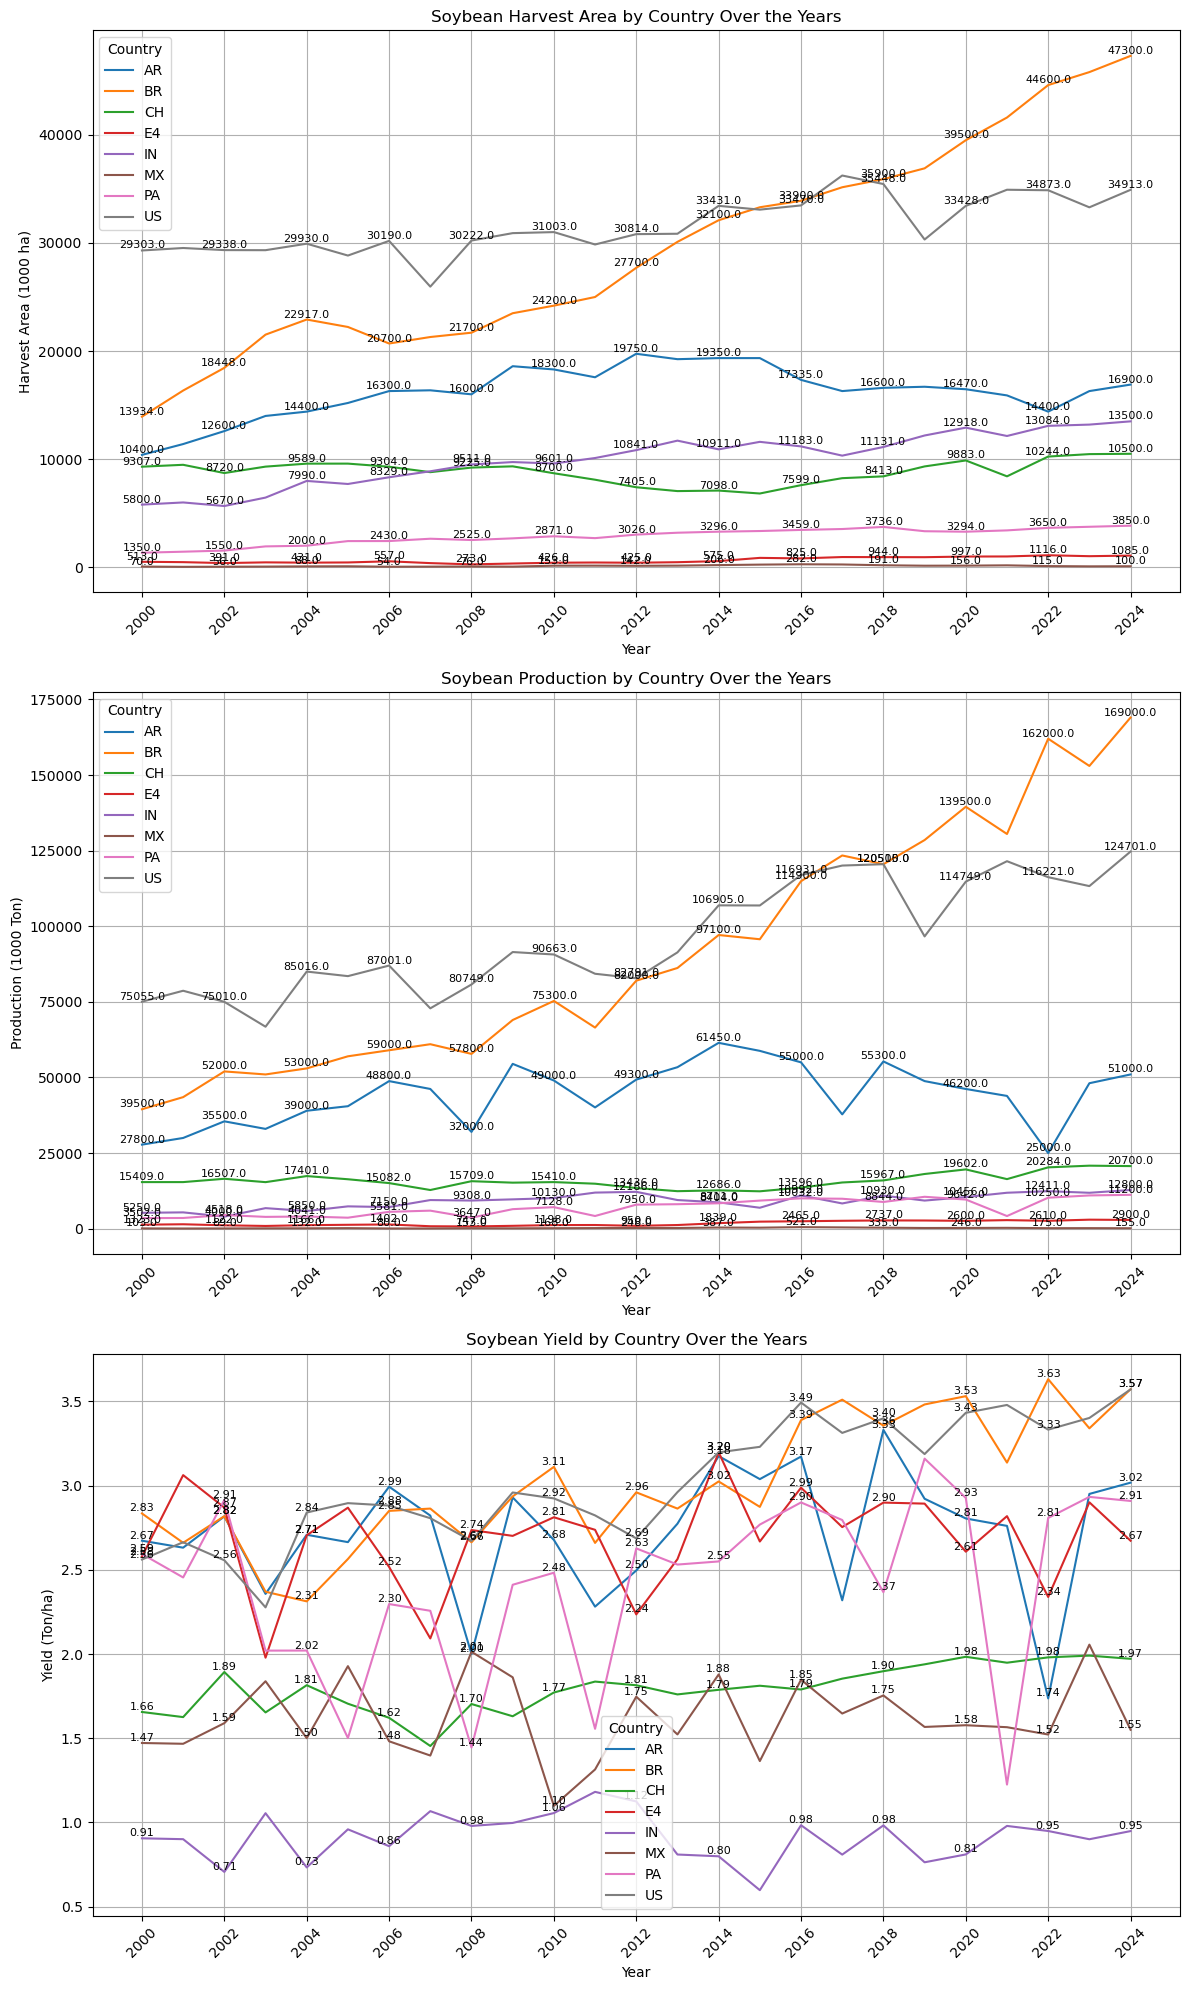

In [53]:
years = pivoted_data['Year'].unique()
countries = pivoted_data['Country'].unique()

fig, axs = plt.subplots(3, 1, figsize=(12, 20), sharex=False)
xticks = years[::2]

# Plot Harvest Area
for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    axs[0].plot(country_data['Year'], country_data['Harvest area'], label=country)
    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Harvest area'].values
        if value.size > 0:
            axs[0].text(year, value[0], f"{value[0]:.1f}", ha='center', va='bottom', fontsize=8)
axs[0].set_title("Soybean Harvest Area by Country Over the Years")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Harvest Area (1000 ha)")
axs[0].legend(title="Country")
axs[0].grid(True)

# Plot Production
for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    axs[1].plot(country_data['Year'], country_data['Production'], label=country)
    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Production'].values
        if value.size > 0:
            axs[1].text(year, value[0], f"{value[0]:.1f}", ha='center', va='bottom', fontsize=8)
axs[1].set_title("Soybean Production by Country Over the Years")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Production (1000 Ton)")
axs[1].legend(title="Country")
axs[1].grid(True)

# Plot Yield
for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    axs[2].plot(country_data['Year'], country_data['Yield'], label=country)
    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Yield'].values
        if value.size > 0:
            axs[2].text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)
axs[2].set_title("Soybean Yield by Country Over the Years")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Yield (Ton/ha)")
axs[2].legend(title="Country")
axs[2].grid(True)

for ax in axs:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=45)

plt.tight_layout()
plt.show()


Abaixo, segue um gráfico que retrata a produção em cada ano caso a área de colheita permanecesse a mesma da safra 20/21 (multiplicação entre a área de cultivo de 2000 e a produtividade em cada ano).

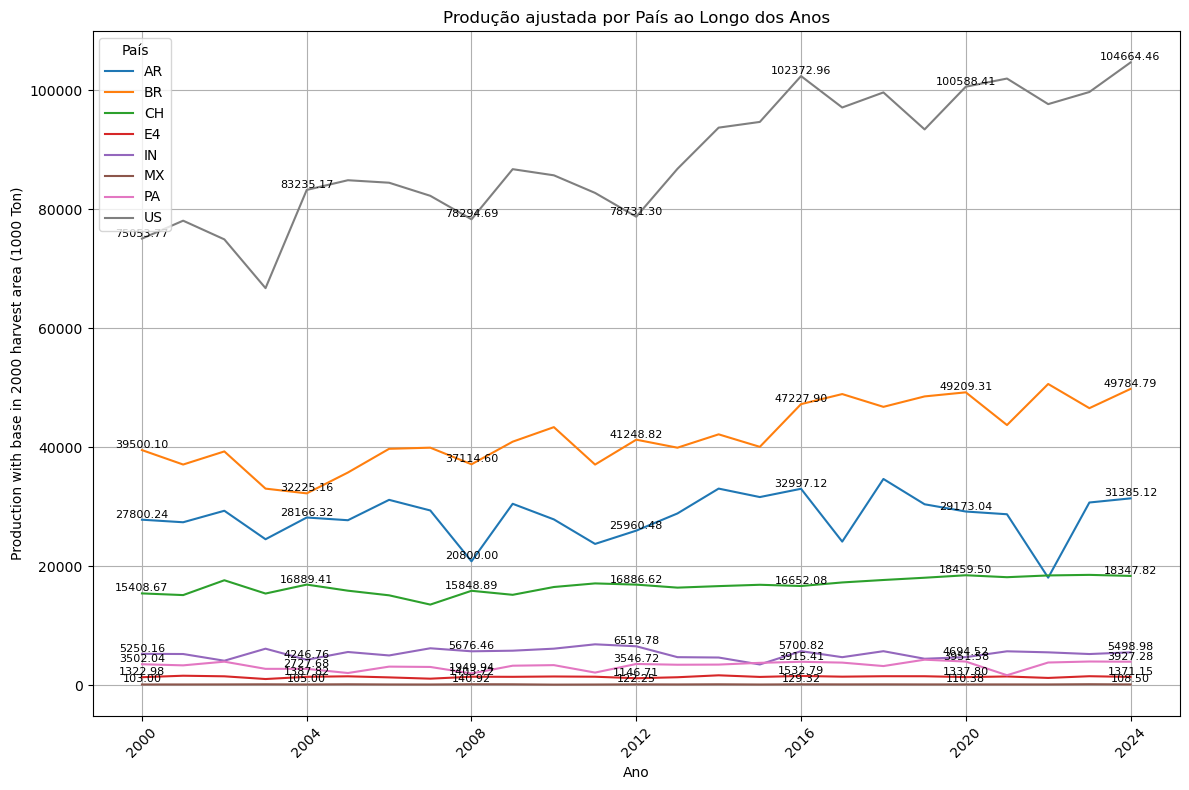

In [54]:

production_1980 = pivoted_data[pivoted_data['Year'] == 2000].set_index('Country')['Harvest area']

pivoted_data['Adjusted Yield'] = pivoted_data.apply(lambda row: row['Yield'] * production_1980[row['Country']], axis=1)

years = pivoted_data['Year'].unique()
xticks = years[::4]  

plt.figure(figsize=(12, 8))

for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    plt.plot(country_data['Year'], country_data['Adjusted Yield'], label=country)

    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Adjusted Yield'].values
        if value.size > 0:
            plt.text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(xticks, rotation=45)  
plt.title("Produção ajustada por País ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Production with base in 2000 harvest area (1000 Ton)")
plt.legend(title="País")
plt.grid(True)

plt.tight_layout()
plt.show()


Como pode ser observado abaixo, temos que quebras são comuns na China, Argentina e no Paraguai (harvest area / crop area). Uma observação a se fazer é que a série de 'Crop area' para os EUA está zerada em todo o período.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


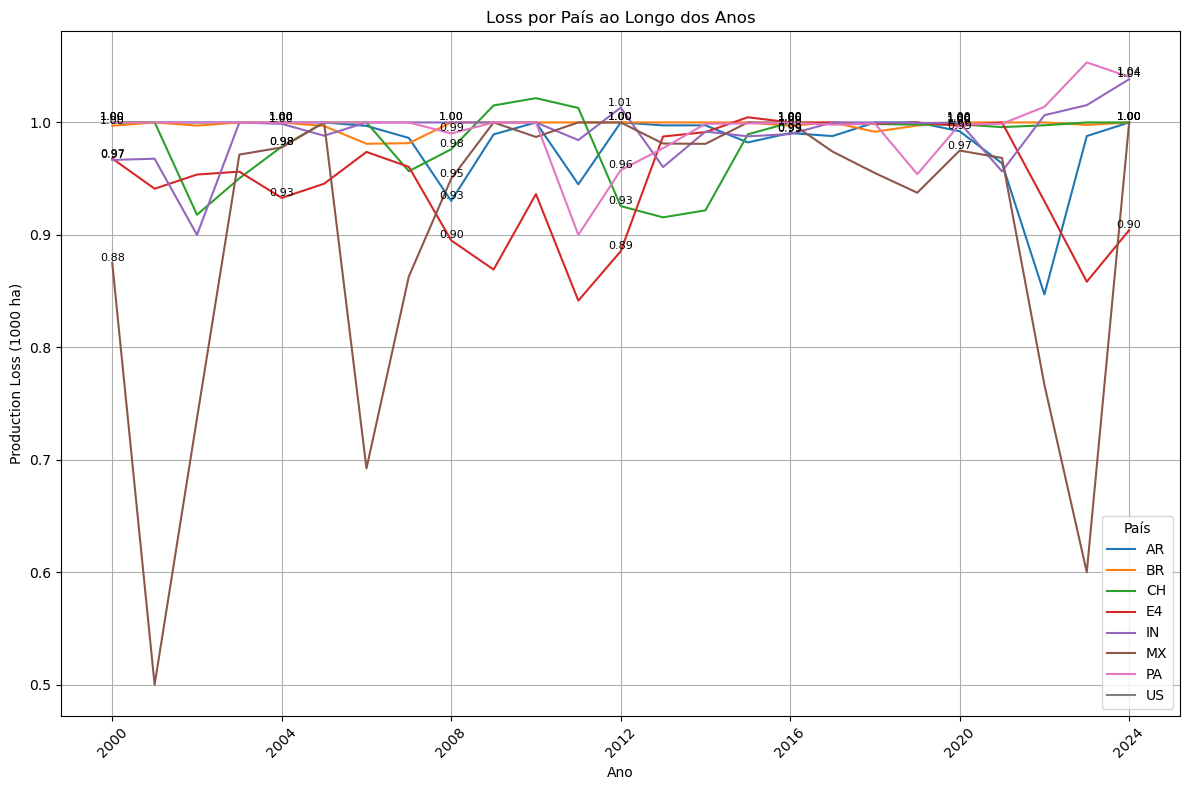

In [55]:
pivoted_data['Loss'] = pivoted_data['Harvest area'] / pivoted_data['Crop area']

plt.figure(figsize=(12, 8))

for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    plt.plot(country_data['Year'], country_data['Loss'], label=country)

    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Loss'].values
        if value.size > 0:
            plt.text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(xticks, rotation=45)  
plt.title("Loss por País ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Production Loss (1000 ha)")
plt.legend(title="País")
plt.grid(True)

plt.tight_layout()
plt.show()



### Análise por participação Global

Abaixo, segue uma análise dos plots da participação de cada país no total de dado sobre a Soja. Os anos referem-se ao ano de plantação e não de colheita (a soja é plantada na safra de outubro até dezembro e colhida em janeiro até março, no geral).


1. Note que a participação brasileira no total da produção da soja beira os 40%. Somado com os 30% de participação dos EUA e 10\% da Argentina, temos cerca de 80\% da produção mundial de soja. 
2. Além disso, cerca de 30% de toda a área mundial destinada à soja é referente à produção brasileira. 
3. Outro ponto interessante é a elevada participação dos estoques Chineses dentre o estoque mundial de Soja, participação crescente ao longo dos anos.
4. O Brasil, desde 2011, figura como o maior exportador de Soja global, com quase 60% do total exportado pela safra 23/24. Quase 90% do que foi exportado nessa safra veio do Brasil e dos EUA.
5. A China é, com larga vantagem, a maior importadora de Soja, sendo responsável por cerca de 60% do total de Soja importada no mundo inteiro. A união europeia é responsável por cerca 10% da importação, diminuindo gradualmente ao longo dos anos.

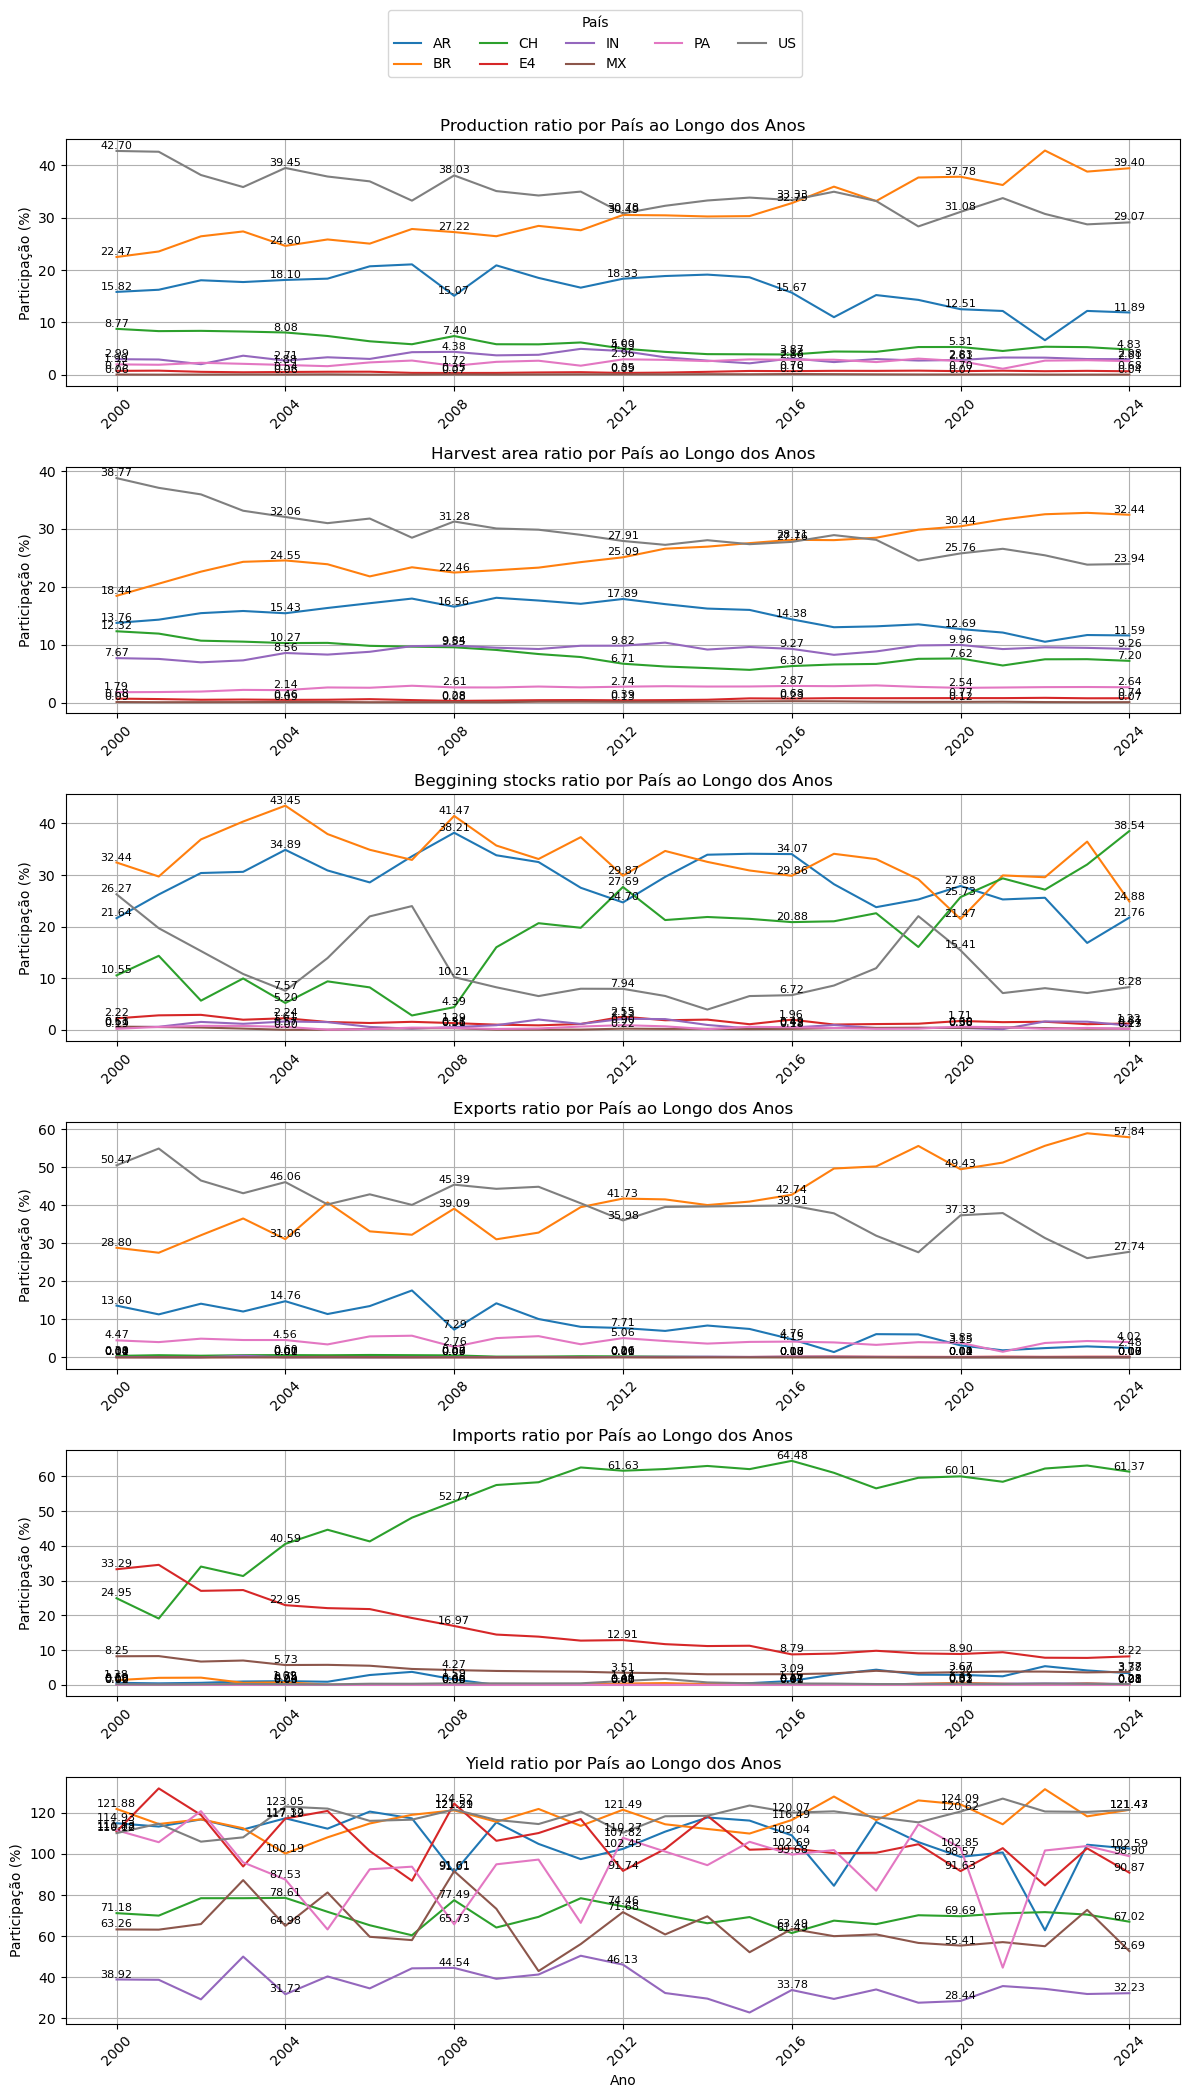

In [56]:
ratio_columns = [
    'Production_ratio', 'Harvest area_ratio', 'Beggining stocks_ratio', 
    'Exports_ratio', 'Imports_ratio', 'Yield_ratio'
]

fig, axs = plt.subplots(len(ratio_columns), 1, figsize=(12, 20))  # Removendo sharex=True

years = pivoted_data['Year'].unique()
xticks = years[::4]

for i, column in enumerate(ratio_columns):
    for country in pivoted_data['Country'].unique():
        country_data = pivoted_data[pivoted_data['Country'] == country]
        axs[i].plot(country_data['Year'], country_data[column], label=country)

        for year in xticks:
            value = country_data.loc[country_data['Year'] == year, column].values
            if value.size > 0:
                axs[i].text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)

    axs[i].set_title(f"{column.replace('_', ' ')} por País ao Longo dos Anos")
    axs[i].set_ylabel("Participação (%)")
    axs[i].grid(True)

    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticks, rotation=45)

axs[-1].set_xlabel("Ano")

fig.legend(pivoted_data['Country'].unique(), title="País", loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()



## Milho

Para o milho, temos como principais produtores:
1. EUA: Aumentou a produção de Soja em cerca de 50% no período, sexto em crescimento total dentre os 7 principais produtores de milho. Mesmo assim, continua como o principal produtor de milho no mundo, posto esse que detém no período inteiro. Novamente, sua expensão de produção está mais relacionada com o aumento de produtividade da plantação. A produtividade da plantação americana se destaca frente as demais sendo cerca 1.7x maior do que a segunda maior produtividade (Europa).
2. China: Segundo maior produtor de milho, expandiu a produção de milho entre 2000 e 2024 em cerca de 2.7 vezes a produção de 2000. Teve um aumento significante na produção de milho, porém a expansão da produção total veio principalmente por conta do aumento na área plantada. Entre os 7 principais produtores, a China é o país com o terceiro maior incremento proporcional de area cultivada, ultrapassando na safra 2009/2010 o total de area destinada à cultura e se mantendo por larga margem em primeiro lugar nesse quesito.
3. Brasil: A partir da safra de 2010/2011 o Brasil se torna o terceiro maior produtor de milho do mundo, ultrapassando a produção europeia. Tanto o aumento de produtividade, quanto a expansão da area cultivada, foram importantes para tal feito. Hoje, o Brasil possui uma produtividade similar a europeia e a chinesa.
4. Europa: A produção europeia teve um aumento relativamente inexpressivo nesses 24 anos, cerca apenas de 13%, em sua totalidade por conta do aumento de produtividade, visto que a area cultivada diminuiu. Mesmo assim, possui a terceira maior produtividade no período. 
5. Argentina: O país observou um grande crescimento na produção (da ordem de quase 600%). Esse crescimento veio principalmente da expansão da area plantada, visto que a produtividade se manteve estacionária. O país possui a segunda maior produtividade de milho.
6. Índia: A Índia teve o maior crescimento proporcional registrado no período, boa parte advindo do ganho em produtividade. Porém, continua sendo o país com a menor produtividade e a menor produção dentre os países analisados, produtividade muito abaixo dos demais.
7. Ucrânia: Por mais que tenha o maior crescimento de produção no período, o país continua sendo o que menos produz.

1. Temos, em ordem de participação na produção global de milho, EUA (31% da produção global), China (24% da produção global) e Brasil (10.5% da produção global). Os demais países possuem cerca de 2% a 4% de participação na produção global. 
2. A participação europeia reduziu ao longo dos anos de maneira evidente (em 2000, representava 10% da produção mundial).
3. Os principais exportadores são os EUA, Brasil, Argentina e Ucrânia.
4. Os principais importadores são Europa, China e Sudeste Asiático (aqui representado por Japão). A participação da importação Japonesa no total reduziu drasticamente ao longo dos anos, em grande parte pelo aumento de importação da China e da Europeia. Em níveis, a importação japonesa permaneceu relativamente constante.
5. Quase 70% dos estoques de milho pertencem à China.

In [88]:
database = pd.read_csv('commodity_data.csv')
data_total = pd.read_csv('commodity_data_total.csv')

corn_data = database[(database['commodityCode'] == int('0440000')) & 
                        (database['countryCode'].isin(['JA', 'E4', 'US', 'BR', 'CH', 'IN', 'UP', 'AR']))].copy()
corn_data_total = data_total[data_total['commodityCode'] == int('0440000')].copy()


In [89]:
corn_data

,commodityCode,countryCode,marketYear,attributeId,value
0,440000,UP,2000,4,1279.0000
1,440000,UP,2000,20,267.0000
2,440000,UP,2000,28,3848.0000
3,440000,UP,2000,57,26.0000
4,440000,UP,2000,88,397.0000
...,...,...,...,...,...
1345,440000,IN,2024,20,2773.0000
1346,440000,IN,2024,28,38000.0000
1347,440000,IN,2024,57,500.0000
1348,440000,IN,2024,88,300.0000


In [90]:
corn_data_total['metric'] = corn_data_total['attributeId'].map({1:'Crop area', 4:'Harvest area', 28: 'Production', 184: 'Yield', 57: 'Imports',
                                                         88: 'Exports', 20: 'Beggining stocks'})

pivoted_data_total = corn_data_total.pivot_table(
    index=['marketYear'],
    columns='metric',
    values='value'
).reset_index()

pivoted_data_total.columns.name = None
pivoted_data_total.rename(columns={'marketYear': 'Year', 'countryCode': 'Country'}, inplace=True)

print(pivoted_data_total.head())

   Year  Beggining stocks  Exports  Harvest area  Imports  Production   Yield
0  1980          111155.0  80308.0      131189.0  74263.0    408734.0  3.1156
1  1981          102541.0  68083.0      133045.0  72177.0    441748.0  3.3203
2  1982          127158.0  59535.0      125240.0  66623.0    439854.0  3.5121
3  1983          149764.0  60955.0      119678.0  58542.0    348338.0  2.9106
4  1984           88982.0  67008.0      128873.0  66256.0    458316.0  3.5563


In [91]:
corn_data['metric'] = corn_data['attributeId'].map({1:'Crop area', 4:'Harvest area', 28: 'Production', 184: 'Yield', 57: 'Imports',
                                                         88: 'Exports', 20: 'Beggining stocks'})

pivoted_data = corn_data.pivot_table(
    index=['marketYear', 'countryCode'],
    columns='metric',
    values='value'
).reset_index()

pivoted_data.columns.name = None
pivoted_data.rename(columns={'marketYear': 'Year', 'countryCode': 'Country'}, inplace=True)

print(pivoted_data.head())

   Year Country  Beggining stocks  Exports  Harvest area  Imports  Production  \
0  2000      AR             761.0   9676.0        2816.0     23.0     15359.0   
1  2000      BR            1667.0   6261.0       12972.0    244.0     41536.0   
2  2000      CH          123799.0   7276.0       23056.0     89.0    106000.0   
3  2000      E4            5120.0    456.0        9266.0   3720.0     51843.0   
4  2000      IN             689.0     95.0        6611.0     50.0     12043.0   

    Yield  
0  5.4542  
1  3.2020  
2  4.5975  
3  5.5950  
4  1.8217  


In [92]:
for column in ['Beggining stocks', 'Exports', 'Harvest area', 'Imports', 'Production', 'Yield']:
    
    total_values = pivoted_data_total.set_index('Year')[column]
    
    pivoted_data[f'{column}_ratio'] = pivoted_data.apply(lambda row: 100*row[column] / total_values[row['Year']], axis=1)

### Análise por montante total

Abaixo, segue a razão das métricas na safra de 2000/2001 para a safra de 2024/2025. 

Em resumo, temos:
1. EUA: Aumentou a produção de Soja em cerca de 50% no período, sexto em crescimento total dentre os 7 principais produtores de milho. Mesmo assim, continua como o principal produtor de milho no mundo, posto esse que detém no período inteiro. Novamente, sua expensão de produção está mais relacionada com o aumento de produtividade da plantação. A produtividade da plantação americana se destaca frente as demais sendo cerca 1.7x maior do que a segunda maior produtividade (Europa).
2. China: Segundo maior produtor de milho, expandiu a produção de milho entre 2000 e 2024 em cerca de 2.7 vezes a produção de 2000. Teve um aumento significante na produção de milho, porém a expansão da produção total veio principalmente por conta do aumento na área plantada. Entre os 7 principais produtores, a China é o país com o terceiro maior incremento proporcional de area cultivada, ultrapassando na safra 2009/2010 o total de area destinada à cultura e se mantendo por larga margem em primeiro lugar nesse quesito.
3. Brasil: A partir da safra de 2010/2011 o Brasil se torna o terceiro maior produtor de milho do mundo, ultrapassando a produção europeia. Tanto o aumento de produtividade, quanto a expansão da area cultivada, foram importantes para tal feito. Hoje, o Brasil possui uma produtividade similar a europeia e a chinesa.
4. Europa: A produção europeia teve um aumento relativamente inexpressivo nesses 24 anos, cerca apenas de 13%, em sua totalidade por conta do aumento de produtividade, visto que a area cultivada diminuiu. Mesmo assim, possui a terceira maior produtividade no período. 
5. Argentina: O país observou um grande crescimento na produção (da ordem de quase 600%). Esse crescimento veio principalmente da expansão da area plantada, visto que a produtividade se manteve estacionária. O país possui a segunda maior produtividade de milho.
6. Índia: A Índia teve o maior crescimento proporcional registrado no período, boa parte advindo do ganho em produtividade. Porém, continua sendo o país com a menor produtividade e a menor produção dentre os países analisados, produtividade muito abaixo dos demais.
7. Ucrânia: Por mais que tenha o maior crescimento de produção no período, o país continua sendo o que menos produz.

In [93]:
production_1980 = pivoted_data[pivoted_data['Year'] == 2000].set_index('Country')[['Production', 'Harvest area', 'Yield']]
production_2024 = pivoted_data[pivoted_data['Year'] == 2024].set_index('Country')[['Production', 'Harvest area', 'Yield']]

production_ratio = production_2024 / production_1980

production_ratio.reset_index(inplace=True)

production_ratio_sorted = production_ratio.sort_values(by='Production', ascending=False)

print(production_ratio_sorted)

  Country  Production  Harvest area     Yield
5      JA   16.000000      3.000000  5.333300
6      UP    6.808732      3.205629  2.123978
0      AR    3.320529      2.272727  1.461039
4      IN    3.155360      1.633641  1.931438
1      BR    3.057589      1.719087  1.778607
2      CH    2.754717      1.938758  1.420859
7      US    1.533357      1.141766  1.342975
3      E4    1.138051      0.928124  1.226184


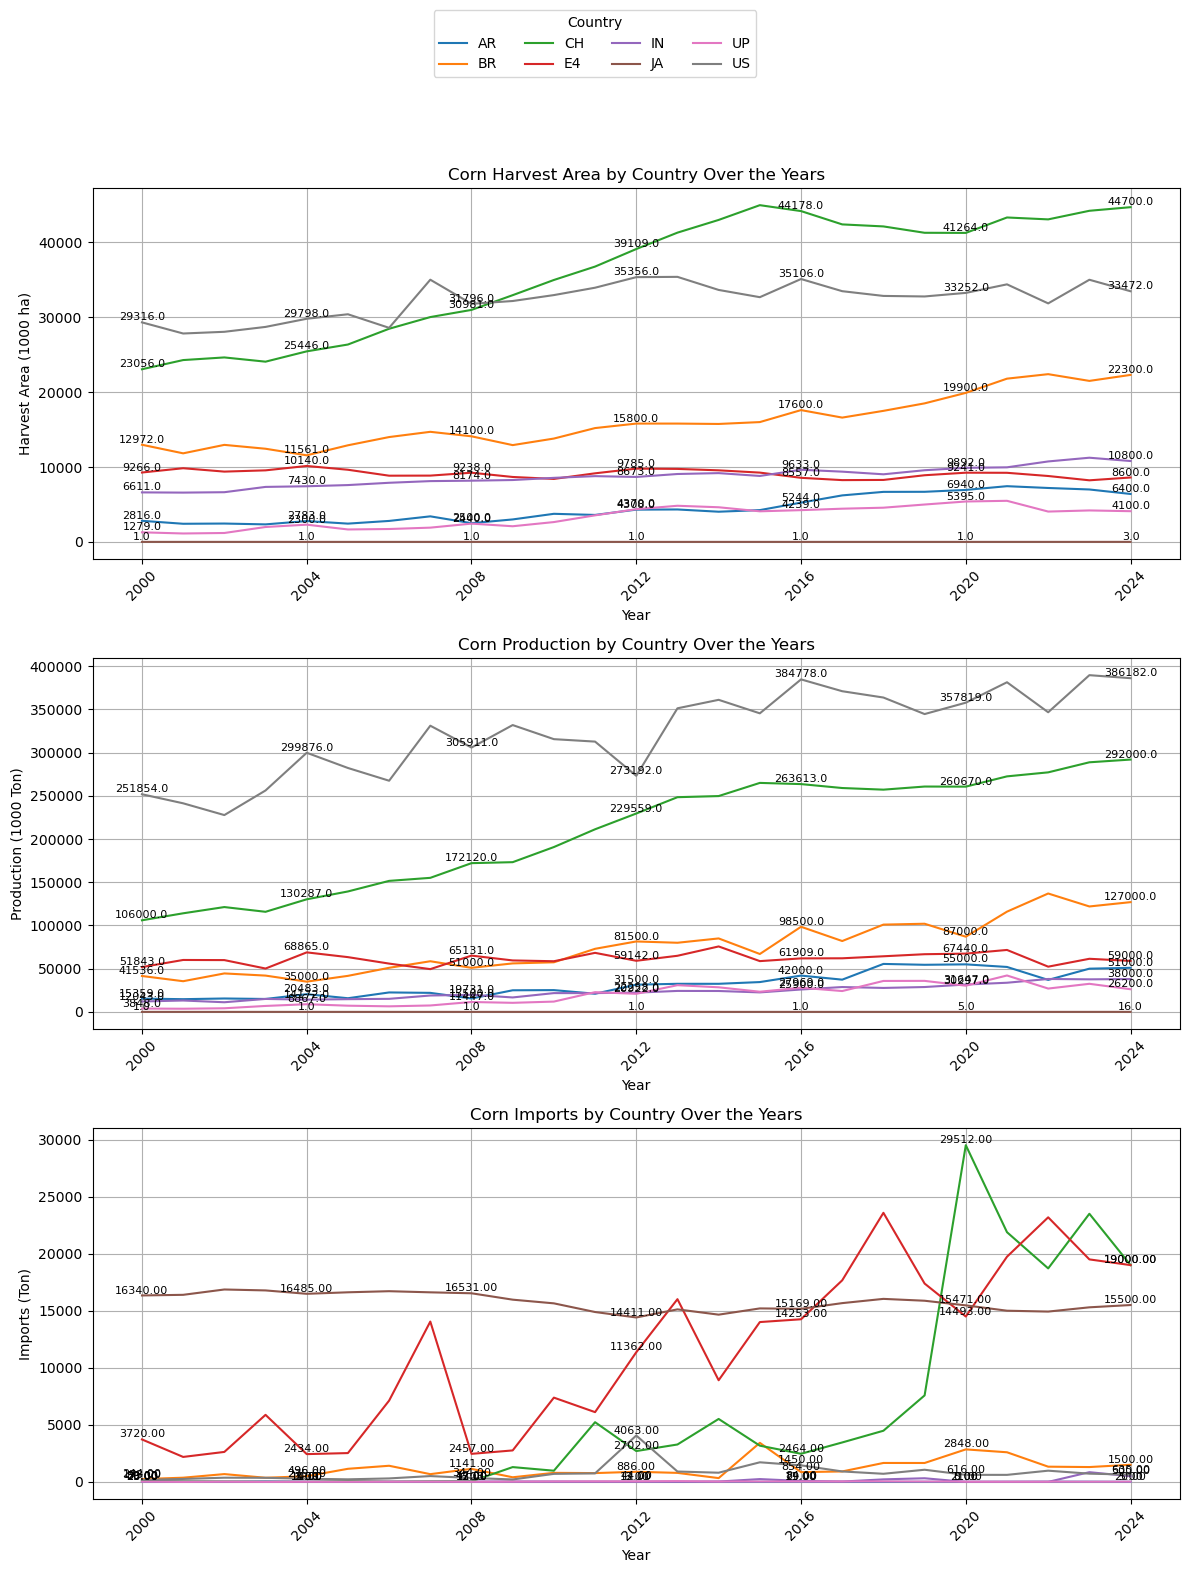

In [112]:
years = pivoted_data['Year'].unique()
countries = pivoted_data['Country'].unique()

fig, axs = plt.subplots(3, 1, figsize=(12, 15), dpi=100, sharex=False)
xticks = years[::4]  

# Plot Harvest Area
for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    axs[0].plot(country_data['Year'], country_data['Harvest area'], label=country)
    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Harvest area'].values
        if value.size > 0:
            axs[0].text(year, value[0], f"{value[0]:.1f}", ha='center', va='bottom', fontsize=8)
axs[0].set_title("Corn Harvest Area by Country Over the Years")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Harvest Area (1000 ha)")
axs[0].grid(True)

# Plot Production
for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    axs[1].plot(country_data['Year'], country_data['Production'], label=country)
    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Production'].values
        if value.size > 0:
            axs[1].text(year, value[0], f"{value[0]:.1f}", ha='center', va='bottom', fontsize=8)
axs[1].set_title("Corn Production by Country Over the Years")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Production (1000 Ton)")
axs[1].grid(True)

# Plot Imports
for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    axs[2].plot(country_data['Year'], country_data['Imports'], label=country)
    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Imports'].values
        if value.size > 0:
            axs[2].text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)
axs[2].set_title("Corn Imports by Country Over the Years")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Imports (Ton)")
axs[2].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Country", loc="upper center", ncol=len(countries) // 2, bbox_to_anchor=(0.5, 1.05))

for ax in axs:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


In [100]:
pivoted_data

,Year,Country,Beggining stocks,Exports,Harvest area,Imports,Production,Yield,Beggining stocks_ratio,Exports_ratio,Harvest area_ratio,Imports_ratio,Production_ratio,Yield_ratio,Adjusted Yield
0,2000,AR,761.0,9676.0,2816.0,23.0,15359.0,5.4542,0.391447,12.611767,2.055534,0.030608,2.596452,126.316033,15359.0272
1,2000,BR,1667.0,6261.0,12972.0,244.0,41536.0,3.2020,0.857479,8.160632,9.468890,0.324710,7.021696,74.156419,41536.3440
2,2000,CH,123799.0,7276.0,23056.0,89.0,106000.0,4.5975,63.680320,9.483590,16.829688,0.118439,17.919390,106.475370,105999.9600
3,2000,E4,5120.0,456.0,9266.0,3720.0,51843.0,5.5950,2.633650,0.594354,6.763701,4.950495,8.764103,129.576878,51843.2700
4,2000,IN,689.0,95.0,6611.0,50.0,12043.0,1.8217,0.354411,0.123824,4.825688,0.066539,2.035879,42.189490,12043.2587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2024,E4,7481.0,3300.0,8600.0,19000.0,59000.0,6.8605,2.392764,1.732256,4.267270,10.334849,4.847218,113.591960,63569.3930
196,2024,IN,2773.0,300.0,10800.0,500.0,38000.0,3.5185,0.886931,0.157478,5.358897,0.271970,3.121937,58.257169,23260.8035
197,2024,JA,1309.0,0.0,3.0,15500.0,16.0,5.3333,0.418678,0.000000,0.001489,8.431061,0.001314,88.305517,5.3333
198,2024,UP,1460.0,23000.0,4100.0,20.0,26200.0,6.3902,0.466974,12.073301,2.034396,0.010879,2.152493,105.805020,8173.0658


Abaixo, segue um gráfico que retrata a produção em cada ano caso a área de colheita permanecesse a mesma da safra 2000/2001 (multiplicação entre a área de cultivo de 2000 e a produtividade em cada ano).

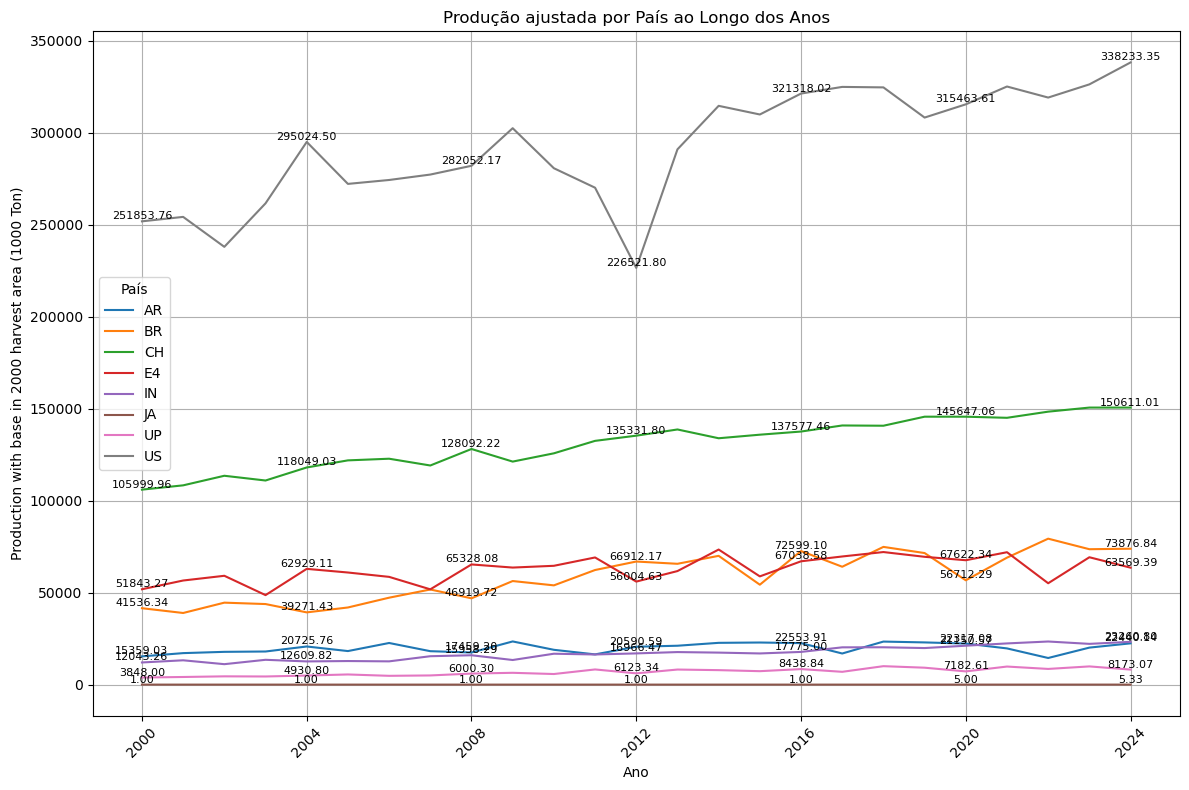

In [95]:

production_1980 = pivoted_data[pivoted_data['Year'] == 2000].set_index('Country')['Harvest area']

pivoted_data['Adjusted Yield'] = pivoted_data.apply(lambda row: row['Yield'] * production_1980[row['Country']], axis=1)

years = pivoted_data['Year'].unique()
xticks = years[::4]  

plt.figure(figsize=(12, 8))

for country in countries:
    country_data = pivoted_data[pivoted_data['Country'] == country]
    plt.plot(country_data['Year'], country_data['Adjusted Yield'], label=country)

    for year in xticks:
        value = country_data.loc[country_data['Year'] == year, 'Adjusted Yield'].values
        if value.size > 0:
            plt.text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(xticks, rotation=45)  
plt.title("Produção ajustada por País ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Production with base in 2000 harvest area (1000 Ton)")
plt.legend(title="País")
plt.grid(True)

plt.tight_layout()
plt.show()


### Análise por participação Global

1. Temos, em ordem de participação na produção global de milho, EUA (31% da produção global), China (24% da produção global) e Brasil (10.5% da produção global). Os demais países possuem cerca de 2% a 4% de participação na produção global. 
2. A participação europeia reduziu ao longo dos anos de maneira evidente (em 2000, representava 10% da produção mundial).
3. Os principais exportadores são os EUA, Brasil, Argentina e Ucrânia.
4. Os principais importadores são Europa, China e Sudeste Asiático (aqui representado por Japão). A participação da importação Japonesa no total reduziu drasticamente ao longo dos anos, em grande parte pelo aumento de importação da China e da Europeia. Em níveis, a importação japonesa permaneceu relativamente constante.
5. Quase 70% dos estoques de milho pertencem à China.

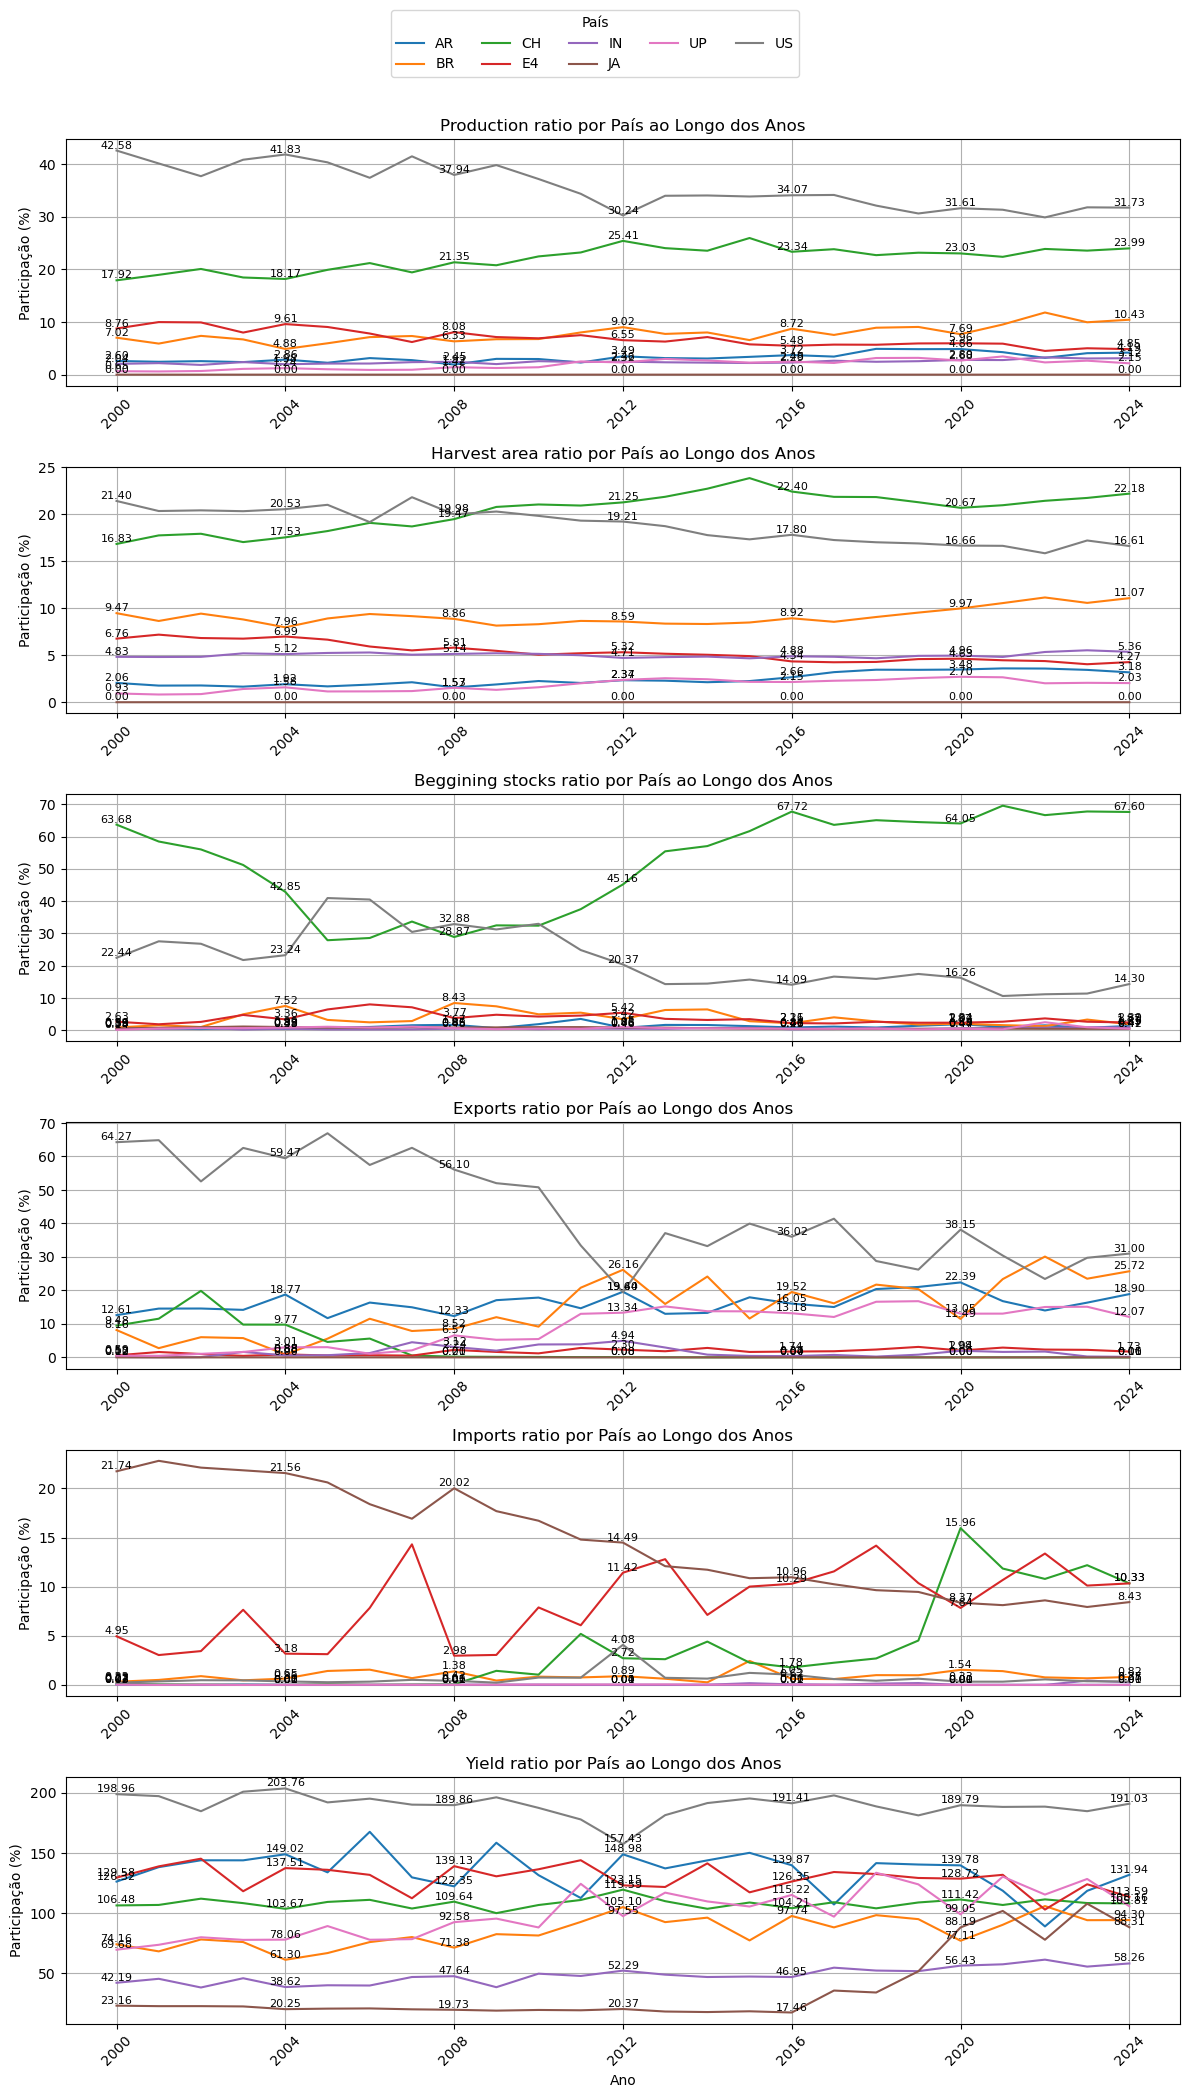

In [96]:
ratio_columns = [
    'Production_ratio', 'Harvest area_ratio', 'Beggining stocks_ratio', 
    'Exports_ratio', 'Imports_ratio', 'Yield_ratio'
]

fig, axs = plt.subplots(len(ratio_columns), 1, figsize=(12, 20))  # Removendo sharex=True

years = pivoted_data['Year'].unique()
xticks = years[::4]

for i, column in enumerate(ratio_columns):
    for country in pivoted_data['Country'].unique():
        country_data = pivoted_data[pivoted_data['Country'] == country]
        axs[i].plot(country_data['Year'], country_data[column], label=country)

        for year in xticks:
            value = country_data.loc[country_data['Year'] == year, column].values
            if value.size > 0:
                axs[i].text(year, value[0], f"{value[0]:.2f}", ha='center', va='bottom', fontsize=8)

    axs[i].set_title(f"{column.replace('_', ' ')} por País ao Longo dos Anos")
    axs[i].set_ylabel("Participação (%)")
    axs[i].grid(True)

    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticks, rotation=45)

axs[-1].set_xlabel("Ano")

fig.legend(pivoted_data['Country'].unique(), title="País", loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

